In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
trainDf=pd.read_csv("train.csv")
print(trainDf.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

In [3]:
print(trainDf.shape)

(42000, 785)


In [4]:
y_train=trainDf["label"].values
X_train=trainDf.iloc[:,1:].values.reshape(-1,28,28)
X_train=X_train.astype(np.float32)/255.0
print(f"Size of y_train : {len(y_train)}\nSize of X_train : {X_train.shape}\n")

Size of y_train : 42000
Size of X_train : (42000, 28, 28)



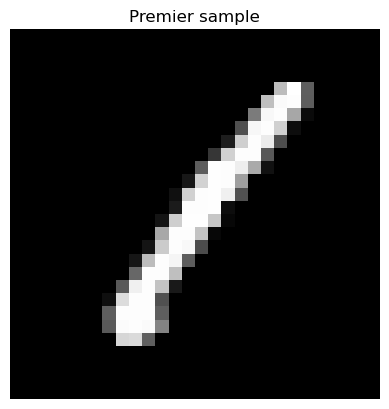

In [5]:
plt.imshow(X_train[0],cmap="gray")
plt.title("Premier sample")
plt.axis("off")
plt.show()

In [15]:
sobelX=np.array([
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
]) #detection de bords horizontaux

sobelY=np.array([
    [-1,-2,-1],
    [0,0,0],
    [1,2,1]
]) #detection de bords verticaux

prewittX=np.array([
    [-1,0,1],
    [-1,0,1],
    [-1,0,1]
]) #detection de bords horizontaux (comme sobelX mais moins marqué)

laplacien=np.array([
    [0,-1,0],
    [-1,4,-1],
    [0,-1,0]
]) #detection de bords toutes directions

laplacienPlus=np.array([
    [-1,-1,-1],
    [-1,8,-1],
    [-1,-1,-1]
]) #detection de bords toutes directions (laplacien plus marqué)

blur=np.array([
    [1/9,1/9,1/9],
    [1/9,1/9,1/9],
    [1/9,1/9,1/9]
]) #flou

gaussien=np.array([
    [1/16,2/16,1/16],
    [2/16,4/16,2/16],
    [1/16,2/16,1/16]
]) #flou plus doux

sharpen=np.array([
    [0,-1,0],
    [-1,5,-1],
    [0,-1,0]
]) #accentuation contours

In [6]:
def padding(img,pad_size=0):
    if pad_size==0:
        return img
    else:
        newImg=np.zeros((img.shape[0]+2*pad_size,img.shape[1]+2*pad_size))
        for w in range(pad_size,newImg.shape[0]-pad_size):
            for h in range(pad_size,newImg.shape[1]-pad_size):
                newImg[w][h]=img[w-pad_size][h-pad_size]
        return newImg

In [81]:
def conv2d(images,nb_kernels,kernel_size,pad_size=0,stride=1,specificKernel=None,extractKernels=False):
    outputs=[]
    imgKernels=[]
    for img in images:
        convolutions=[]
        if specificKernel is not None:
            kernels=specificKernel
        else:
            kernels=createRandomKernels(nb_kernels,(kernel_size,kernel_size))
        for i,kernel in enumerate(kernels):
            padded=padding(img,pad_size)
            newImg=np.zeros((((padded.shape[0]-kernel.shape[0])//stride)+1,((padded.shape[1]-kernel.shape[1])//stride)+1))
            for w in range(newImg.shape[0]):
                for h in range(newImg.shape[1]):
                    result=0
                    for kw in range(kernel.shape[0]):
                        for kh in range(kernel.shape[1]):
                            result+=kernel[kw][kh]*padded[w*stride+kw][h*stride+kh]
                    newImg[w][h]=result
            convolutions.append(newImg)
        outputs.append(convolutions)
        imgKernels.append(kernels)
    if extractKernels:
        return outputs,imgKernels
    return outputs

In [32]:
def createRandomKernels(nb_kernels,dim):
    kernels=[]
    for i in range(nb_kernels):
        kernels.append(np.random.randn(dim[0],dim[1]))
    return kernels

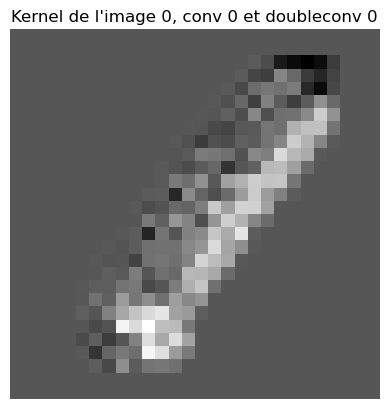

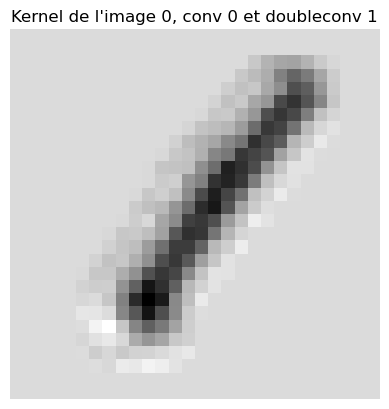

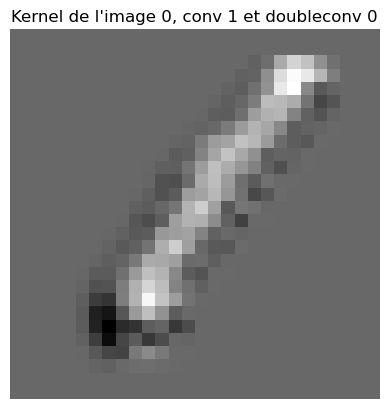

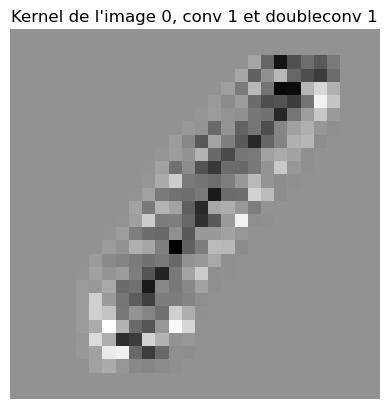

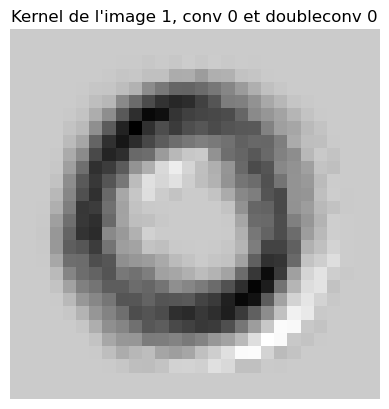

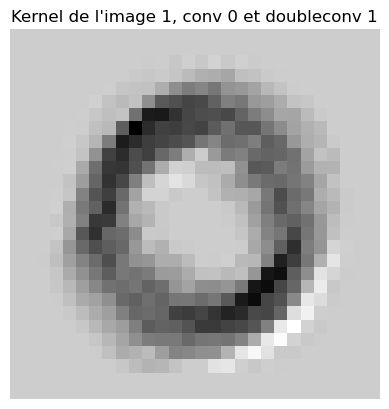

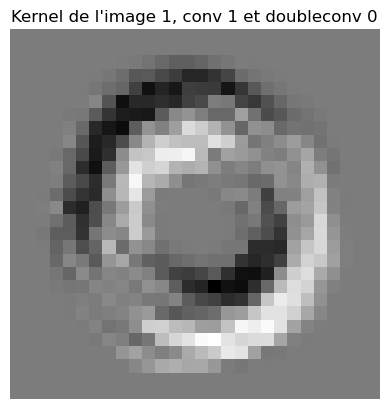

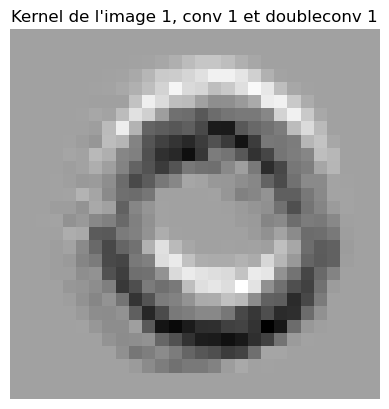

In [99]:
kernels=[sobelX,sobelY,prewittX,laplacien,laplacienPlus,blur,gaussien,sharpen]
images=[X_train[0],X_train[1]]
doubleConv,tripleConv=[],[]
convoluted=conv2d(images,nb_kernels=2,kernel_size=3,pad_size=1)
for img in range(len(images)):
    doubleConv.append(conv2d(convoluted[img],nb_kernels=2,kernel_size=3,pad_size=1))
for img in range(len(images)):
    for conv in range(len(convoluted)):
        for double in range(len(doubleConv)):
            plt.imshow(doubleConv[img][conv][double],cmap="gray")
            plt.title(f"Kernel de l'image {img}, conv {conv} et doubleconv {double}")
            plt.axis("off")
            plt.show()